In [2]:
%load_ext autoreload
%autoreload 2

import utils
import config
import pandas as pd
import plotly.express as px

In [4]:
df = config.Keywords.load(as_dataframe=True)

In [ ]:
prompt_texts = df.apply(config.Keywords.template, axis=1)
prompt_texts.head()

count    151014.000000
mean         14.100765
std           4.268287
min           1.000000
25%          11.000000
50%          14.000000
75%          17.000000
max         251.000000
Name: description, dtype: float64

<Axes: title={'center': 'Keyword Types'}, ylabel='count'>

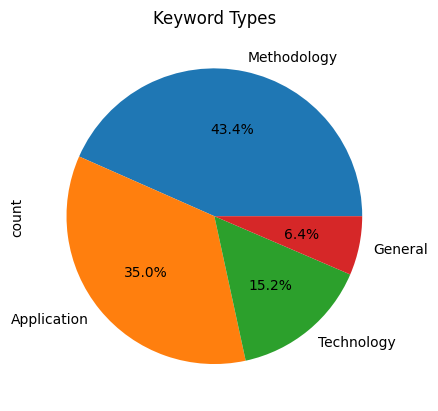

In [6]:
df.type.value_counts().plot.pie(autopct="%.1f%%", title="Keyword Types")

In [7]:
import tiktoken
encoding = tiktoken.encoding_for_model(tiktoken.get_encoding("gpt-4o"))
prompt_tokens = prompt_texts.map(lambda text: len(encoding.encode(text)))
token_stats = prompt_tokens.describe()
token_stats

ValueError: Unknown encoding gpt-4o.
Plugins found: ['tiktoken_ext.openai_public']
tiktoken version: 0.12.0 (are you on latest?)

In [ ]:
total_tokens = prompt_tokens.sum()
total_tokens